<a href="https://colab.research.google.com/github/cherrypicker1122/FraudDetectionPractice/blob/main/test_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import math
import os.path as path
import shutil

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from keras import optimizers, metrics, callbacks

# 랜덤 시드 고정
np.random.seed(22)

In [3]:
import sys

class Preprocessing:

    def load_data(self):
        #file path csv 읽어서 output 데이터 , input 데이터 나눠서 리턴

        # colab 에서 실행중이면 google drive mount 하기
        if 'google.colab' in sys.modules :
            from google.colab import drive # colab에서 실행중이면 google.colab이 sys.modules에 있다고 한다
            drive.mount('/content/drive')
            data = pd.read_csv("/content/drive/MyDrive/creditcard.csv", delimiter=',', dtype=np.float32)
        else :
            # colab아닌 환경이라면 그냥 읽어오기
            data = pd.read_csv("dataset/creditcard.csv", delimiter=',', dtype=np.float32)

        x_data = np.array(data.iloc[:,0:-1].values, dtype=np.float32) # input 컬럼들 추출
        y_data = np.array(data.iloc[:,[-1]].values, dtype=np.float32) # output(class) 컬럼 추출

        return x_data, y_data

    def split_sample(self, x_data, y_data):
        # 랜덤 시드 : 22, 원 데이터 10% 데이터로 샘플 나누기 . 샘플 나눌 때 분포 비슷하게 해서 샘플 나누기
        return train_test_split(x_data, y_data, test_size = 0.1,  random_state=22, stratify=y_data)


## 기본
Normalization + Batch Normalization + Dropout 만 추가하여 테스트

In [6]:
pr = Preprocessing()
x_data, y_data = pr.load_data()
x_train, x_test, y_train, y_test = pr.split_sample(x_data, y_data)

# Normalization
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

# 기본
# Model Build
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),        # 입력층
    tf.keras.layers.BatchNormalization(synchronized=True),  # 각 배치마다 normalization 수행
    tf.keras.layers.Dropout(0.2),                           # dropout 으로 랜덤으로 신경망 끄기
    tf.keras.layers.Dense(64, activation = 'relu'),         # 은닉층
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu'),         # 은닉층
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'relu'),         # 은닉층
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')          # 출력층
])

# Hyper-parameter tunning (optmizer, cost function)
learning_rate = 0.008
batch_size = 4096
epoch= 2000


# ndarray -> dataset 변환 후 batch size세팅
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.batch(batch_size)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss = 'binary_crossentropy',
              metrics=[ tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Training
try:
    history = model.fit(dataset, epochs=epoch)
except Exception as e:
    print(e)
    raise e

model.save('fraud.basic')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/2000
63/63 [==============================] - 6s 50ms/step - loss: 0.2769 - precision_2: 0.0171 - recall_2: 0.7269
Epoch 2/2000
63/63 [==============================] - 3s 43ms/step - loss: 0.0214 - precision_2: 0.7967 - recall_2: 0.6456
Epoch 3/2000
63/63 [==============================] - 3s 41ms/step - loss: 0.0129 - precision_2: 0.8434 - recall_2: 0.6321
Epoch 4/2000
63/63 [==============================] - 4s 68ms/step - loss: 0.0098 - precision_2: 0.8512 - recall_2: 0.6456
Epoch 5/2000
63/63 [==============================] - 3s 43ms/step - loss: 0.0083 - precision_2: 0.8377 - recall_2: 0.5824
Epoch 6/2000
63/63 [==============================] - 3s 41ms/step - loss: 0.0077 - precision_2: 0.8507 - recall_2: 0.6433
Epoch 7/2000
63/63 [==============================] - 4s 60ms/step - loss: 0.0074 - precision_2: 0.8765 - recall_2: 0.6411
Epoch 8/20

In [7]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               3968      
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_9 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 64)               

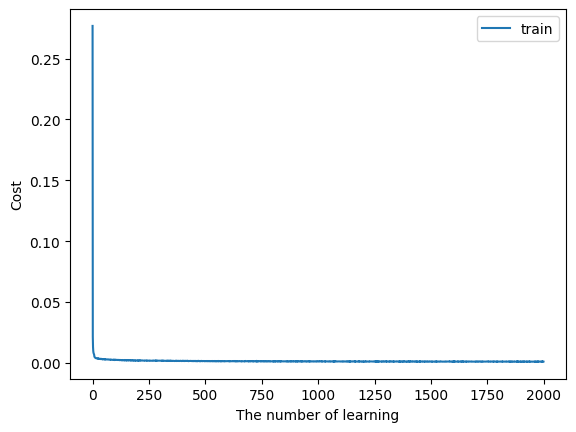

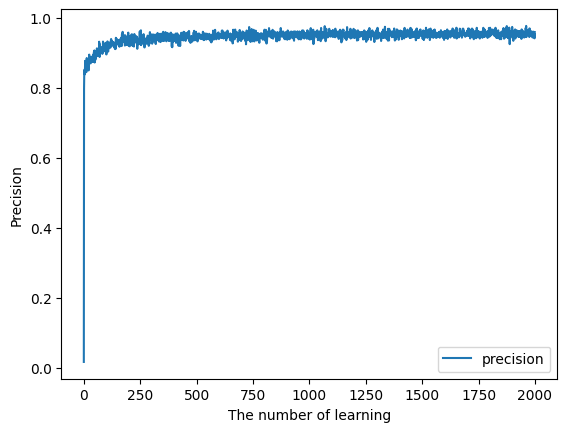

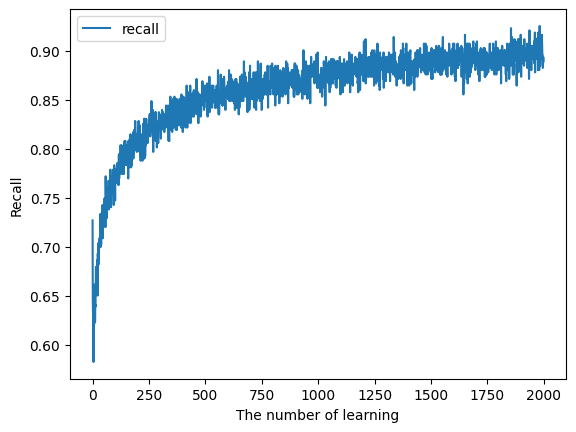

891/891 - 2s - loss: 0.0581 - precision_2: 1.0000 - recall_2: 0.0816 - 2s/epoch - 3ms/step
precision: 1.0, recall: 0.08163265138864517


In [17]:
# Visualization

plt.plot(history.history['loss'], label='train')
plt.xlabel("The number of learning")
plt.ylabel("Cost")
plt.legend()
plt.show()

plt.plot(history.history['precision_2'], label='precision')
plt.xlabel("The number of learning")
plt.ylabel("Precision")
plt.legend()
plt.show()

plt.plot(history.history['recall_2'], label='recall')
plt.xlabel("The number of learning")
plt.ylabel("Recall")
plt.legend()
plt.show()

# Evaluation
loss, precision, recall = model.evaluate(x_test, y_test, verbose=2)
print(f"precision: {precision}, recall: {recall}")


In [9]:
Ann_predict = tf.cast( model.predict(x_test) > 0.5, dtype = tf.float32)
print("Test Report = \n", classification_report(Ann_predict, y_test))

891/891 [==============================] - 2s 2ms/step
Test Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28477
         1.0       0.08      1.00      0.15         4

    accuracy                           1.00     28481
   macro avg       0.54      1.00      0.58     28481
weighted avg       1.00      1.00      1.00     28481



## 개선시도 1
배운 것  모두 다 넣어서 테스트
- dropout
- standard scaler
- batch normalization
- weight initialization
- early stopping with patience
- learning rate decay
- 은닉층 한개 더 추가

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping



# early stopping 을 위한 validation set 추가
pr = Preprocessing()
x_data, y_data = pr.load_data()
x_data, x_test, y_data, y_test = pr.split_sample(x_data,y_data)
x_train, x_validation, y_train, y_validation = pr.split_sample(x_data,y_data)

# Normalization 방법 바꿈. - standard scaler 이용 - data imbalance에 좋음 (normalization 중에는 좋지만 결국에는 )
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.fit_transform(x_validation)
x_test = scaler.fit_transform(x_test)


# Model Build
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer='he_uniform'), # 입력층 에 kaiming weight initialization 추가
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu', kernel_initializer='he_uniform'), # 은닉층
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu', kernel_initializer='he_uniform'), # 은닉층
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'relu', kernel_initializer='he_uniform'), # 은닉층
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation = 'relu', kernel_initializer='he_uniform'), # 은닉층 한 개 더 추가
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력층 : 이진분류 문제이므로 sigmoid 사용
])


# Hyper-parameter tunning (optmizer, cost function)
# T4 GPU에서 실행
batch_size = 4096
epoch= 5000

# learning rate decay 관련
warmup_epoch = int(epoch * 0.1)
init_lr = 1e-4
min_lr = 1e-7
power = 1. #????

# early stopping patience 개수 지정
patience = 2000  # 일단 크게 잡고 시작


# ndarray -> dataset 변환 후 batch size세팅
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.batch(batch_size)

# learning rate decay with warmup : 1e-4~ 1e-6 까지 learning rate 조정되도록 세팅
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate = init_lr,
    decay_steps = epoch - warmup_epoch,
    end_learning_rate = min_lr,
    power = power
)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_scheduler),
              loss = 'binary_crossentropy',
              metrics=[ tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience) # with 1000 patience

callback = [callbacks.ModelCheckpoint('improvement.keras')]

# Training
history = model.fit(dataset, validation_data=(x_validation, y_validation),  epochs=epoch,  callbacks=[es, callback])

model.save('fraud.improvement')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/5000
57/57 [==============================] - 21s 53ms/step - loss: 0.8882 - precision_3: 0.0021 - recall_3: 0.6266 - val_loss: 0.7585 - val_precision_3: 7.8003e-04 - val_recall_3: 0.2727
Epoch 2/5000
57/57 [==============================] - 3s 57ms/step - loss: 0.8449 - precision_3: 0.0022 - recall_3: 0.6491 - val_loss: 0.7533 - val_precision_3: 0.0019 - val_recall_3: 0.6364
Epoch 3/5000
57/57 [==============================] - 3s 58ms/step - loss: 0.8118 - precision_3: 0.0023 - recall_3: 0.6617 - val_loss: 0.7283 - val_precision_3: 0.0027 - val_recall_3: 0.8182
Epoch 4/5000
57/57 [==============================] - 4s 68ms/step - loss: 0.7820 - precision_3: 0.0024 - recall_3: 0.6541 - val_loss: 0.7096 - val_precision_3: 0.0028 - val_recall_3: 0.8182
Epoch 5/5000
57/57 [==============================] - 3s 46ms/step - loss: 0.7547 - precision_3: 0.002